In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import IPython.display as ipd
import librosa.display
import pandas as pd
import soundfile as sf
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,matthews_corrcoef,roc_auc_score,classification_report

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [5]:

# directories
real_male_dir = '/content/drive/My Drive/TMU MSC/MRP/AUDIO/REAL/male'
fake_male_dir = '/content/drive/My Drive/TMU MSC/MRP/AUDIO/FAKE/male'

# Function to load audio files and convert them to a consistent sample rate
def load_audio_files(directory, sample_rate=22050):
    audio_files = []
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            path = os.path.join(directory, filename)
            audio, sr = librosa.load(path, sr=sample_rate)
            audio_files.append(audio)
    return audio_files

real_male_audios = load_audio_files(real_male_dir)
fake_male_audios = load_audio_files(fake_male_dir)

In [6]:
real_female_dir = '/content/drive/My Drive/TMU MSC/MRP/AUDIO/REAL/female'
fake_female_dir = '/content/drive/My Drive/TMU MSC/MRP/AUDIO/FAKE/female'
real_female_audios = load_audio_files(real_female_dir)
fake_female_audios = load_audio_files(fake_female_dir)

In [7]:
def slice_audio(audio, window_length=1, sr=22050):
    # Window length = 1 sec
    sample_length = window_length * sr
    return [audio[i:i+sample_length] for i in range(0, len(audio), sample_length) if len(audio[i:i+sample_length]) == sample_length]

# Slicing real and fake audio samples
real_male_slices = [slice for audio in real_male_audios for slice in slice_audio(audio, window_length=1)]
fake_male_slices = [slice for audio in fake_male_audios for slice in slice_audio(audio, window_length=1)]
real_female_slices = [slice for audio in real_female_audios for slice in slice_audio(audio, window_length=1)]
fake_female_slices = [slice for audio in fake_female_audios for slice in slice_audio(audio, window_length=1)]

In [8]:
def time_shift(audio, shift_max, sr):
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(audio, shift)

# Apply time shift
real_augmented = [time_shift(audio, 1000, 22050) for audio in real_female_slices]

In [9]:
real_augmented += [librosa.effects.pitch_shift(audio, sr=22050, n_steps=4) for audio in real_female_slices]

In [10]:
real_augmented += [librosa.effects.time_stretch(audio,rate =  1.5) for audio in real_female_slices]

In [11]:
real_female = real_augmented + real_female_slices

In [12]:
len(real_female)

2716

3063
19389
2716
6805


<BarContainer object of 4 artists>

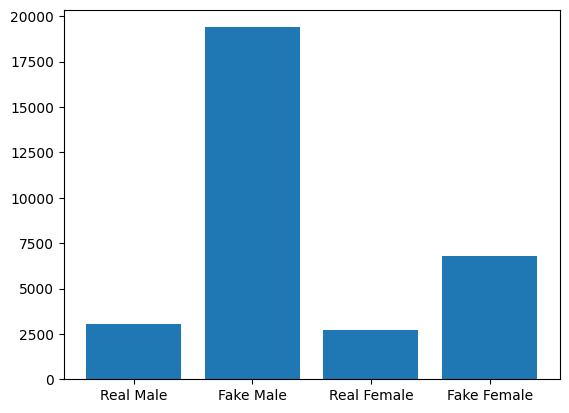

In [13]:
print(len(real_male_slices))
print(len(fake_male_slices))
print(len(real_female))
print(len(fake_female_slices))
plt.bar(['Real Male', 'Fake Male', 'Real Female', 'Fake Female'], [len(real_male_slices), len(fake_male_slices), len(real_female), len(fake_female_slices)])

In [14]:
#feature extraction and dataframe creation
sr = 22050
def extract_audio_features(files):
    features_list = []

    # Iterate over all files
    for y in files:
        # Extract features
        # Chromagram
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr).mean()

        # Root Mean Square Energy
        rms = librosa.feature.rms(y=y).mean()

        # Spectral Centroid
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()

        # Spectral Bandwidth
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()

        # Spectral Rolloff
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr).mean()

        # Zero Crossing Rate
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y).mean()

        # Mel-Frequency Cepstral Coefficients (MFCCs)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20).mean(axis=1)

        # Spectral Contrast
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr).mean()

        # Concatenate features as values for dataframe
        features = np.hstack((
            chroma_stft, rms, spectral_centroid, spectral_bandwidth, rolloff, zero_crossing_rate,
            mfccs, spectral_contrast
        ))

        features_list.append(features)

    # Create  DataFrame
    feature_names = [
        'chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate'
    ] + [f'mfcc{i+1}' for i in range(mfccs.shape[0])] + ['spectral_contrast']

    df = pd.DataFrame(features_list, columns=feature_names)

    return df

features__male_real = extract_audio_features(real_male_slices)
features__male_fake = extract_audio_features(fake_male_slices)
features__female_real = extract_audio_features(real_female)
features__female_fake = extract_audio_features(fake_female_slices)


In [15]:
print(features__male_real.shape)
print(features__male_fake.shape)
print(features__female_real.shape)
print(features__female_fake.shape)

(3063, 27)
(19389, 27)
(2716, 27)
(6805, 27)


In [16]:
features__female_real["gender"] = 1
features__female_fake["gender"] =1
features__male_real["gender"] = 0
features__male_fake["gender"] =0
features__female_real["label"] = 1
features__female_fake["label"] =0
features__male_real["label"] = 0
features__male_fake["label"] =0
final_df = pd.concat([features__female_real,features__female_fake,features__male_real,features__male_fake],axis=0)
print(final_df.shape)

(31973, 29)


In [17]:
final_df.label.value_counts()

label
0    29257
1     2716
Name: count, dtype: int64

In [18]:
train_df, temp_df = train_test_split(final_df, test_size=0.20, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [19]:
#splitting in to independent and dependent variables
X = train_df.drop('label', axis=1)
y = train_df['label']

In [20]:
X_val = val_df.drop(columns=['label'])
y_val = val_df['label']

In [21]:
X_val['gender'].value_counts()

gender
0    2254
1     943
Name: count, dtype: int64

In [22]:
random_forest = RandomForestClassifier(max_depth=None, n_estimators=200, random_state=42)
xgboost = XGBClassifier(learning_rate=0.2, max_depth=10, n_estimators=200, random_state=42)
lda = LinearDiscriminantAnalysis(solver='svd')
qda = QuadraticDiscriminantAnalysis(reg_param=0.0)


In [23]:
random_forest.fit(X, y)
xgboost.fit(X, y)
lda.fit(X, y)
qda.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis()

In [24]:
# Make predictions on validation set
y_val_pred_rf = random_forest.predict(X_val)
y_val_pred_xgb = xgboost.predict(X_val)
y_val_pred_lda = lda.predict(X_val)
y_val_pred_qda = qda.predict(X_val)

# Classification report for Random Forest
print("Random Forest:")
print(classification_report(y_val, y_val_pred_rf))

# Classification report for XGBoost
print("XGBoost:")
print(classification_report(y_val, y_val_pred_xgb))

# Classification report for LDA
print("LDA:")
print(classification_report(y_val, y_val_pred_lda))

# Classification report for QDA
print("QDA:")
print(classification_report(y_val, y_val_pred_qda))

Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2944
           1       0.95      0.97      0.96       253

    accuracy                           0.99      3197
   macro avg       0.97      0.98      0.98      3197
weighted avg       0.99      0.99      0.99      3197

XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2944
           1       0.96      0.99      0.97       253

    accuracy                           1.00      3197
   macro avg       0.98      0.99      0.99      3197
weighted avg       1.00      1.00      1.00      3197

LDA:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2944
           1       0.87      0.93      0.90       253

    accuracy                           0.98      3197
   macro avg       0.93      0.96      0.94      3197
weighted avg       0.98      0.98      0.98  

In [25]:
# Analyze misclassifications for each gender
val_df['predicted_rf'] = y_val_pred_rf
val_df['predicted_xgb'] = y_val_pred_xgb
val_df['predicted_lda'] = y_val_pred_lda
val_df['predicted_qda'] = y_val_pred_qda

In [26]:
# Misclassified incidents
misclassified_rf = val_df[val_df['label'] != val_df['predicted_rf']]
misclassified_xgb = val_df[val_df['label'] != val_df['predicted_xgb']]
misclassified_lda = val_df[val_df['label'] != val_df['predicted_lda']]
misclassified_qda = val_df[val_df['label'] != val_df['predicted_qda']]

# Count misclassifications by gender
misclassified_by_gender_rf = misclassified_rf['gender'].value_counts()
misclassified_by_gender_xgb = misclassified_xgb['gender'].value_counts()
misclassified_by_gender_lda = misclassified_lda['gender'].value_counts()
misclassified_by_gender_qda = misclassified_qda['gender'].value_counts()

print("Misclassifications by Gender for Random Forest:")
print(misclassified_by_gender_rf)

print("Misclassifications by Gender for XGBoost:")
print(misclassified_by_gender_xgb)

print("Misclassifications by Gender for LDA:")
print(misclassified_by_gender_lda)

print("Misclassifications by Gender for QDA:")
print(misclassified_by_gender_qda)

Misclassifications by Gender for Random Forest:
gender
1    21
Name: count, dtype: int64
Misclassifications by Gender for XGBoost:
gender
1    13
Name: count, dtype: int64
Misclassifications by Gender for LDA:
gender
1    52
0     2
Name: count, dtype: int64
Misclassifications by Gender for QDA:
gender
1    290
Name: count, dtype: int64


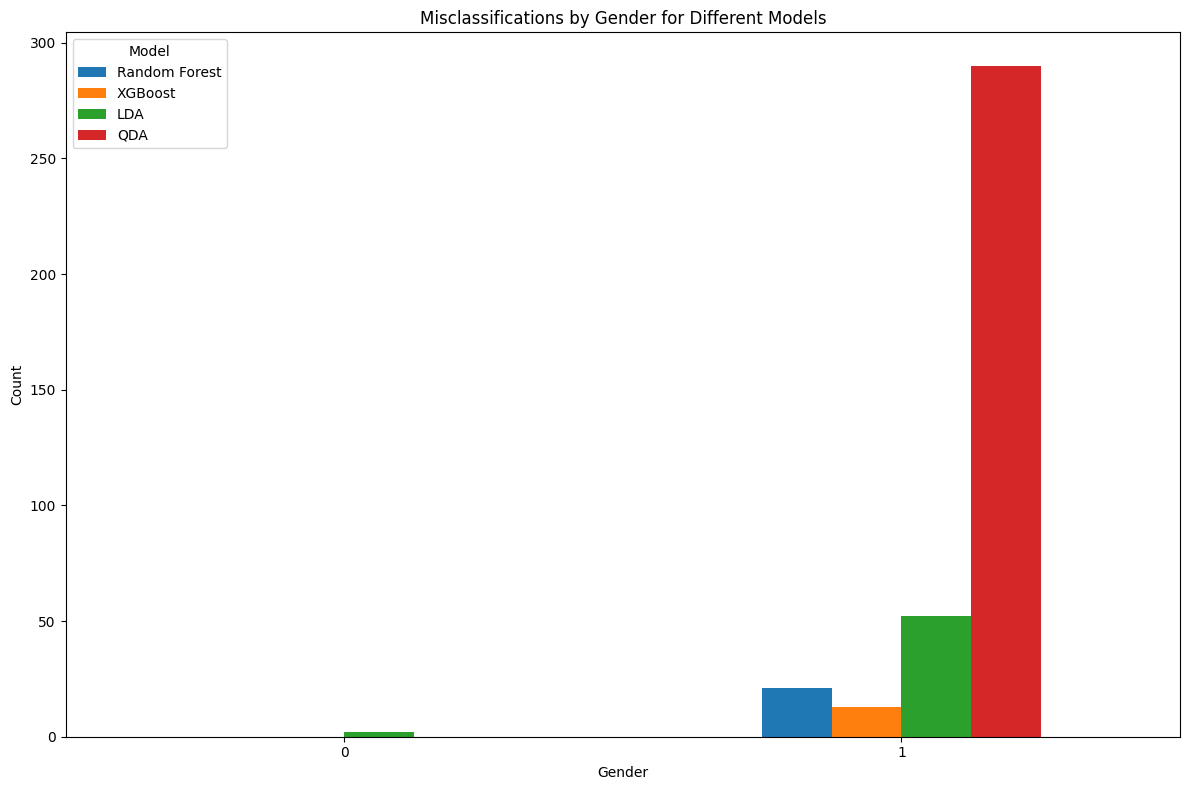

In [27]:
misclassified_df = pd.DataFrame({
    'Random Forest': misclassified_by_gender_rf,
    'XGBoost': misclassified_by_gender_xgb,
    'LDA': misclassified_by_gender_lda,
    'QDA': misclassified_by_gender_qda
})

# Plotting the combined misclassification data
ax = misclassified_df.plot(kind='bar', figsize=(12, 8))
plt.title('Misclassifications by Gender for Different Models')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

In [28]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 22.8 MB/s eta 0:00:00


In [30]:
misclassified_rf.shape

(21, 33)

In [48]:
import shap


# For Random Forest
explainer_rf = shap.TreeExplainer(random_forest)
shap_rf = explainer_rf.shap_values(misclassified_rf.drop(columns=['label', 'predicted_rf', 'predicted_xgb', 'predicted_lda', 'predicted_qda']))

# For XGBoost
explainer_xgb = shap.Explainer(xgboost)
shap_xgb = explainer_xgb.shap_values(misclassified_xgb.drop(columns=['label', 'predicted_rf', 'predicted_xgb', 'predicted_lda', 'predicted_qda']))



# For LDA
explainer_lda = shap.KernelExplainer(lda.predict_proba, misclassified_lda.drop(columns=['label', 'predicted_rf', 'predicted_xgb', 'predicted_lda', 'predicted_qda']))
shap_lda = explainer_lda.shap_values(misclassified_lda.drop(columns=['label', 'predicted_rf', 'predicted_xgb', 'predicted_lda', 'predicted_qda']))

# For QDA
explainer_qda = shap.KernelExplainer(qda.predict_proba, misclassified_qda.drop(columns=['label', 'predicted_rf', 'predicted_xgb', 'predicted_lda', 'predicted_qda']))
shap_qda = explainer_qda.shap_values(misclassified_qda.drop(columns=['label', 'predicted_rf', 'predicted_xgb', 'predicted_lda', 'predicted_qda']))



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/290 [00:00<?, ?it/s]

In [49]:
shap_rf.shape

(21, 28, 2)

In [50]:
shap_lda.shape

(54, 28, 2)

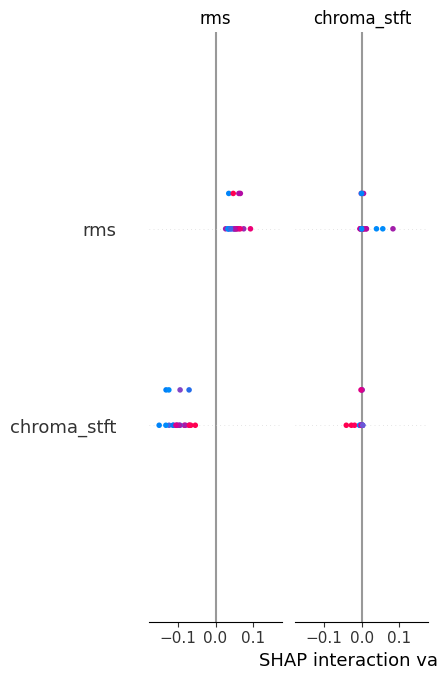

In [54]:
shap.initjs()
features = misclassified_rf.drop(columns=['label', 'predicted_rf', 'predicted_xgb', 'predicted_lda', 'predicted_qda'])


# Plot the SHAP summary plot
shap.summary_plot(shap_rf, features)
plt.show()

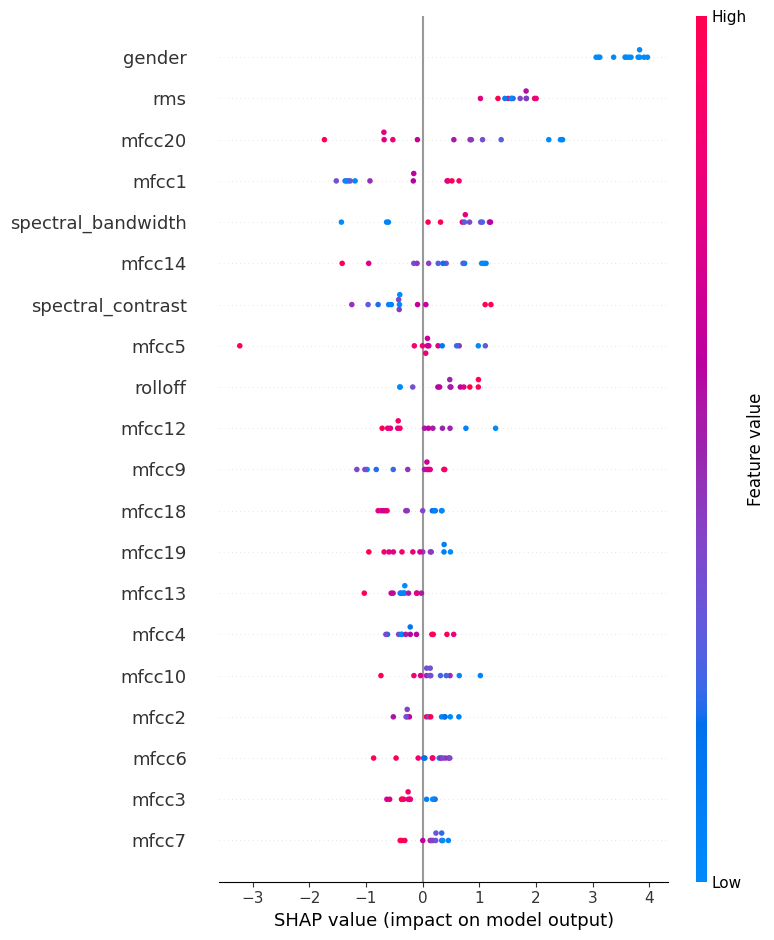

In [34]:

features_xgb= misclassified_xgb.drop(columns=['label', 'predicted_rf', 'predicted_xgb', 'predicted_lda', 'predicted_qda'])


# Plot the SHAP summary plot XGBoost
shap.summary_plot(shap_xgb, features_xgb) #
plt.show()


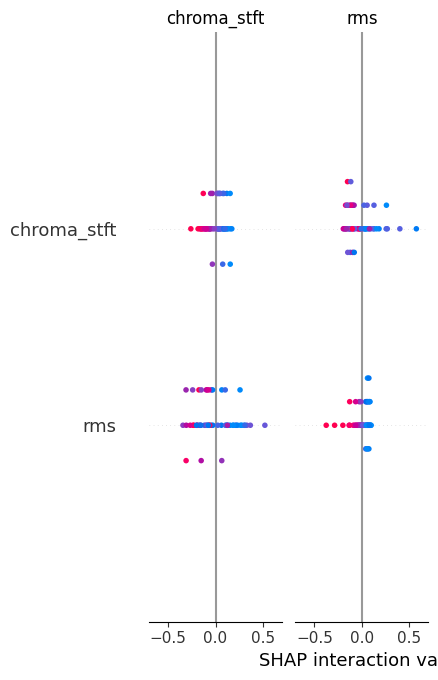

In [35]:
features_lda = misclassified_lda.drop(columns=['label', 'predicted_rf', 'predicted_xgb', 'predicted_lda', 'predicted_qda'])



# Plot the SHAP summary plot LDA
shap.summary_plot(shap_lda, features_lda)
plt.show()


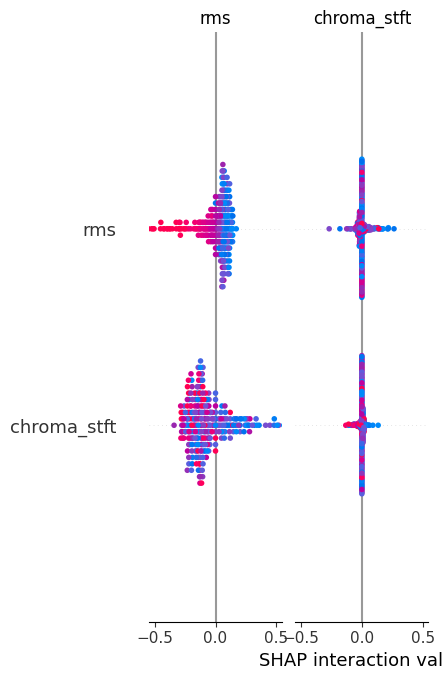

In [36]:
features_qda = misclassified_qda.drop(columns=['label', 'predicted_rf', 'predicted_xgb', 'predicted_lda', 'predicted_qda'])



# Plot the SHAP summary plot QDA
shap.summary_plot(shap_qda, features_qda) # 
plt.show()

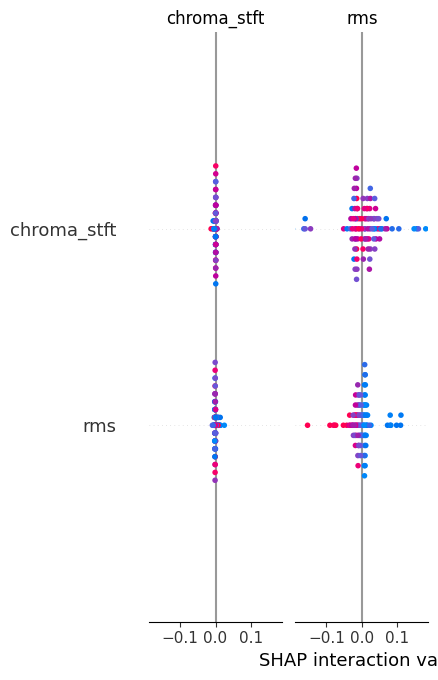

In [37]:
#shap value of first 100 instances
shap.initjs()
explainer_rf = shap.Explainer(random_forest)
shap_rf = explainer_rf.shap_values(X_val[:100])

# Plot the SHAP summary plot
shap.summary_plot(shap_rf, X_val[:100]) 
plt.show()

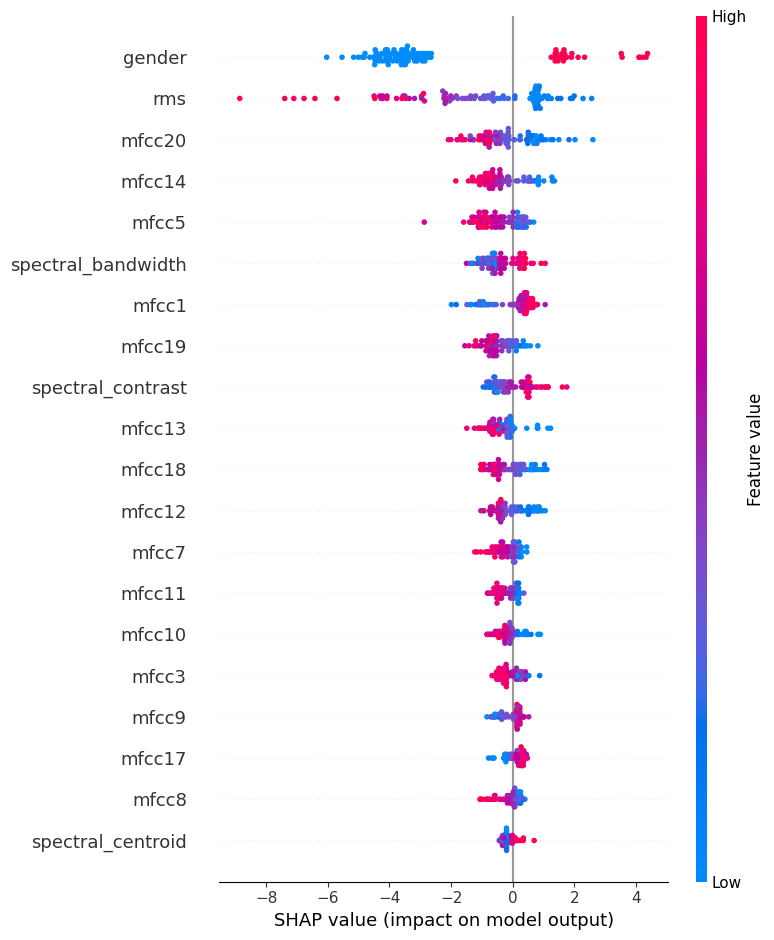

In [38]:
#shap value of first 100 instances of validation set
shap.initjs()
explainer_xgb = shap.Explainer(xgboost)
shap_xgb = explainer_xgb.shap_values(X_val[:100])

# Plot the SHAP summary plot
shap.summary_plot(shap_xgb, X_val[:100]) # mean absolute SHAP values
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

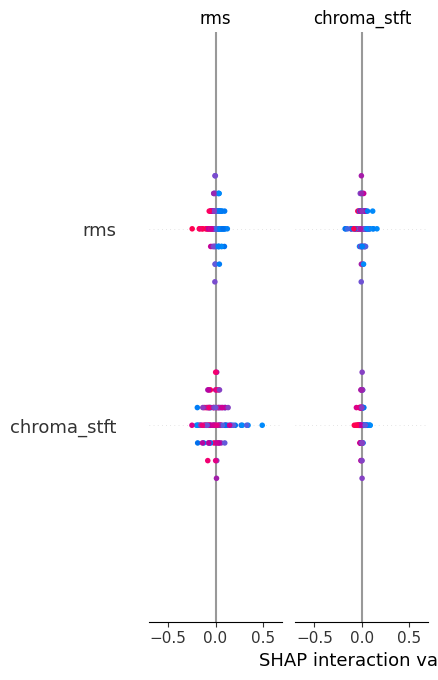

In [39]:
#shap value of first 100 instances
shap.initjs()
explainer_lda = shap.KernelExplainer(lda.predict_proba,X_val[:100])
shap_lda = explainer_lda.shap_values(X_val[:100])

# Plot the SHAP summary plot
shap.summary_plot(shap_lda, X_val[:100])
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

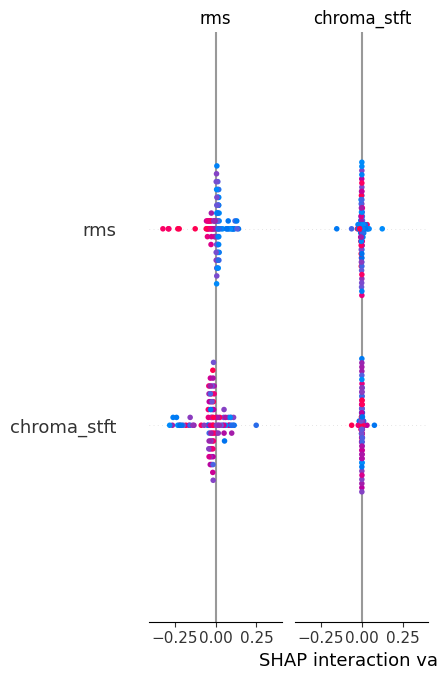

In [40]:
#shap value of first 100 instances
shap.initjs()
explainer_qda = shap.KernelExplainer(qda.predict_proba,X_val[:100])
shap_qda = explainer_qda.shap_values(X_val[:100])

# Plot the SHAP summary plot
shap.summary_plot(shap_qda, X_val[:100])
plt.show()

**Results on test set**

In [41]:
X_test = test_df.drop(columns=['label'])
y_test = test_df['label']

In [42]:
# Make predictions on test set
y_test_pred_rf = random_forest.predict(X_test)
y_test_pred_xgb = xgboost.predict(X_test)
y_test_pred_lda = lda.predict(X_test)
y_test_pred_qda = qda.predict(X_test)

# Classification report for Random Forest
print("Random Forest:")
print(classification_report(y_test, y_test_pred_rf))

# Classification report for XGBoost
print("XGBoost:")
print(classification_report(y_test, y_test_pred_xgb))

# Classification report for LDA
print("LDA:")
print(classification_report(y_test, y_test_pred_lda))

# Classification report for QDA
print("QDA:")
print(classification_report(y_test, y_test_pred_qda))

Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2934
           1       0.96      0.95      0.95       264

    accuracy                           0.99      3198
   macro avg       0.98      0.97      0.97      3198
weighted avg       0.99      0.99      0.99      3198

XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2934
           1       0.97      0.98      0.98       264

    accuracy                           1.00      3198
   macro avg       0.98      0.99      0.99      3198
weighted avg       1.00      1.00      1.00      3198

LDA:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2934
           1       0.85      0.88      0.87       264

    accuracy                           0.98      3198
   macro avg       0.92      0.93      0.93      3198
weighted avg       0.98      0.98      0.98  

In [43]:
# Analyze misclassifications for each gender
test_df['predicted_rf'] = y_test_pred_rf
test_df['predicted_xgb'] = y_test_pred_xgb
test_df['predicted_lda'] = y_test_pred_lda
test_df['predicted_qda'] = y_test_pred_qda

In [44]:
# Misclassified incidents
misclassified_rf_test = test_df[test_df['label'] != test_df['predicted_rf']]
misclassified_xgb_test = test_df[test_df['label'] != test_df['predicted_xgb']]
misclassified_lda_test = test_df[test_df['label'] != test_df['predicted_lda']]
misclassified_qda_test = test_df[test_df['label'] != test_df['predicted_qda']]

# Count misclassifications by gender
misclassified_by_gender_rf_test = misclassified_rf_test['gender'].value_counts()
misclassified_by_gender_xgb_test = misclassified_xgb_test['gender'].value_counts()
misclassified_by_gender_lda_test = misclassified_lda_test['gender'].value_counts()
misclassified_by_gender_qda_test= misclassified_qda_test['gender'].value_counts()

print("Misclassifications by Gender for Random Forest:")
print(misclassified_by_gender_rf_test)

print("Misclassifications by Gender for XGBoost:")
print(misclassified_by_gender_xgb_test)

print("Misclassifications by Gender for LDA:")
print(misclassified_by_gender_lda_test)

print("Misclassifications by Gender for QDA:")
print(misclassified_by_gender_qda_test)

Misclassifications by Gender for Random Forest:
gender
1    25
Name: count, dtype: int64
Misclassifications by Gender for XGBoost:
gender
1    12
Name: count, dtype: int64
Misclassifications by Gender for LDA:
gender
1    65
0     7
Name: count, dtype: int64
Misclassifications by Gender for QDA:
gender
1    295
Name: count, dtype: int64


In [45]:
# For Random Forest
explainer_rf_test= shap.Explainer(random_forest)
shap_rf_test = explainer_rf_test.shap_values(misclassified_rf_test.drop(columns=['label', 'predicted_rf', 'predicted_xgb', 'predicted_lda', 'predicted_qda']))

# For XGBoost
explainer_xgb_test = shap.Explainer(xgboost)
shap_xgb_test = explainer_xgb_test.shap_values(misclassified_xgb_test.drop(columns=['label', 'predicted_rf', 'predicted_xgb', 'predicted_lda', 'predicted_qda']))



# For LDA
explainer_lda_test = shap.KernelExplainer(lda.predict_proba, misclassified_lda_test.drop(columns=['label', 'predicted_rf', 'predicted_xgb', 'predicted_lda', 'predicted_qda']))
shap_lda_test = explainer_lda_test.shap_values(misclassified_lda_test.drop(columns=['label', 'predicted_rf', 'predicted_xgb', 'predicted_lda', 'predicted_qda']))

# For QDA
explainer_qda_test = shap.KernelExplainer(qda.predict_proba, misclassified_qda_test.drop(columns=['label', 'predicted_rf', 'predicted_xgb', 'predicted_lda', 'predicted_qda']))
shap_qda_test = explainer_qda.shap_values(misclassified_qda_test.drop(columns=['label', 'predicted_rf', 'predicted_xgb', 'predicted_lda', 'predicted_qda']))

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

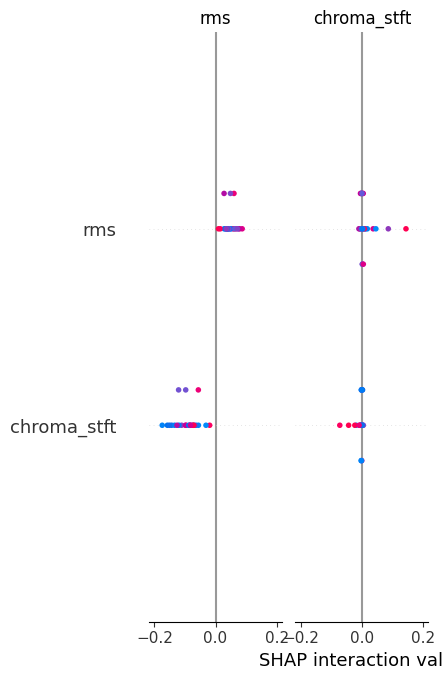

In [46]:
shap.initjs()
features_test = misclassified_rf_test.drop(columns=['label', 'predicted_rf', 'predicted_xgb', 'predicted_lda', 'predicted_qda'])

# Plot the SHAP summary plot
shap.summary_plot(shap_rf_test, features_test) # mean absolute SHAP values
plt.show()

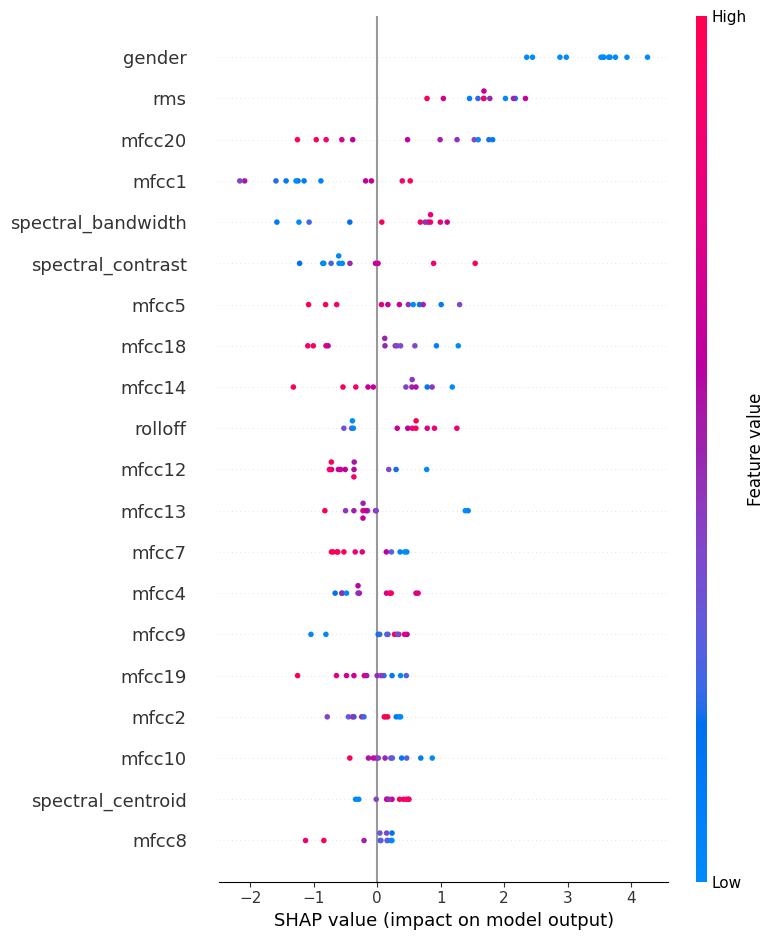

In [47]:

features_xgb_test= misclassified_xgb_test.drop(columns=['label', 'predicted_rf', 'predicted_xgb', 'predicted_lda', 'predicted_qda'])

# Plot the SHAP summary plot
shap.summary_plot(shap_xgb_test, features_xgb_test)
plt.show()


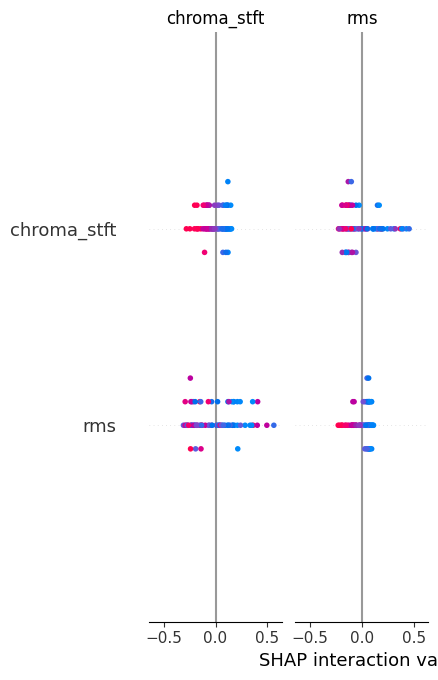

In [48]:
features_lda_test= misclassified_lda_test.drop(columns=['label', 'predicted_rf', 'predicted_xgb', 'predicted_lda', 'predicted_qda'])

# Plot the SHAP summary plot
shap.summary_plot(shap_lda_test, features_lda_test)
plt.show()

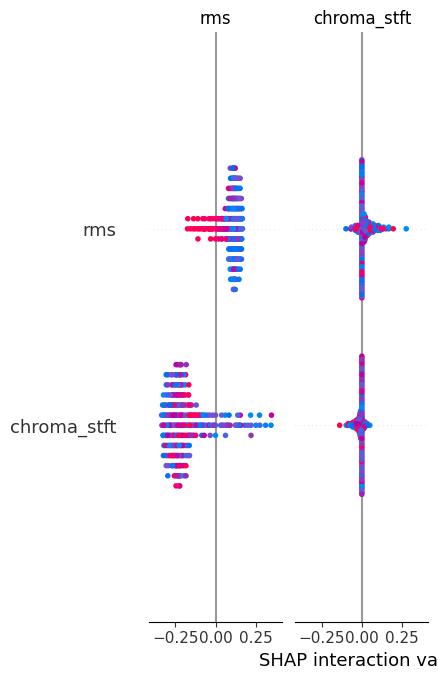

In [49]:
features_qda_test= misclassified_qda_test.drop(columns=['label', 'predicted_rf', 'predicted_xgb', 'predicted_lda', 'predicted_qda'])

# Plot the SHAP summary plot
shap.summary_plot(shap_qda_test, features_qda_test)
plt.show()